In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class PINN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=200, output_dim=1, num_hidden_layers=3, activation_fn=torch.tanh):
        super(PINN, self).__init__()
        self.activation_fn = activation_fn

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)
        ])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        x = self.activation_fn(self.input_layer(inputs))
        for layer in self.hidden_layers:
            x = self.activation_fn(layer(x))
        x = self.output_layer(x)
        return x

In [4]:
def compute_physics_loss(model, x_interior, t_interior, equation="heat", a=1.0, b=1.0, c=-0.5, forcing_fn=None):
    with torch.backends.cudnn.flags(enabled=False):
      u_pred = model(x_interior, t_interior)

    u_t = torch.autograd.grad(u_pred, t_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_interior, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_interior, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    if equation == "heat":
        rhs = a * u_xx
        if forcing_fn is not None:
            rhs += forcing_fn(x_interior, t_interior)
        physics_loss = u_t - rhs

    elif equation == "wave":
        u_tt = torch.autograd.grad(u_t, t_interior, grad_outputs=torch.ones_like(u_t), create_graph=True, retain_graph=True)[0]
        rhs = a * u_xx + b * u_t
        if forcing_fn is not None:
            rhs += forcing_fn(x_interior, t_interior)
        physics_loss = u_tt - rhs

    elif equation == "adv_diff_react":
      rhs = a * u_xx + b * u_x + c * u_pred
      if forcing_fn is not None:
          rhs += forcing_fn(x_interior, t_interior)
      physics_loss = u_t - rhs

    else:
        raise ValueError(f"Unknown equation type: {equation}")

    return torch.mean(physics_loss ** 2)


In [5]:
def compute_initial_condition_loss(model, x_initial, t_initial, initial_func):
    with torch.backends.cudnn.flags(enabled=False):
      u_pred_initial = model(x_initial, t_initial)

    u_true_initial = initial_func(x_initial)
    return torch.mean((u_pred_initial - u_true_initial) ** 2)

In [6]:
def compute_boundary_loss(model, x_boundary_l, t_boundary_l, x_boundary_r, t_boundary_r, boundary_funcs):
    losses = []

    for label, (x, t) in zip(["x_l", "x_r"], [(x_boundary_l, t_boundary_l), (x_boundary_r, t_boundary_r)]):
        bc = boundary_funcs[label]
        bc_type = bc["type"]
        target = bc["value"](t)
        with torch.backends.cudnn.flags(enabled=False):
          u_pred = model(x, t)

        if bc_type == "dirichlet":
            loss = torch.mean((u_pred - target) ** 2)

        elif bc_type == "neumann":
            u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
            loss = torch.mean((u_x - target) ** 2)

        elif bc_type == "robin":
            u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True, retain_graph=True)[0]
            combo = u_x - u_pred
            loss = torch.mean((combo - target) ** 2)

        else:
            raise ValueError(f"Unknown boundary condition type: {bc_type}")

        losses.append(loss)

    return sum(losses)


In [7]:
class DynamicLossWeights(nn.Module):
    def __init__(self):
        super().__init__()
        self.log_sigma_physics = nn.Parameter(torch.tensor(0.0).clamp(min=-5.0))
        self.log_sigma_boundary = nn.Parameter(torch.tensor(0.0).clamp(min=-5.0))
        self.log_sigma_initial = nn.Parameter(torch.tensor(0.0).clamp(min=-5.0))

    def forward(self, physics_loss, boundary_loss, initial_loss):
        loss = (
            0.5 * torch.exp(-2 * self.log_sigma_physics) * physics_loss + self.log_sigma_physics +
            0.5 * torch.exp(-2 * self.log_sigma_boundary) * boundary_loss + self.log_sigma_boundary +
            0.5 * torch.exp(-2 * self.log_sigma_initial) * initial_loss + self.log_sigma_initial
        )
        return loss


In [8]:
def loss_function(model, x_interior, t_interior, x_boundary_l, t_boundary, x_boundary_r, t_boundary_r,
                  x_initial, t_initial, boundary_funcs, initial_func, equation="wave", a=1.0, b=1.0, c=-0.5, forcing_fn=None):
    physics_loss = compute_physics_loss(model=model, x_interior=x_interior, t_interior=t_interior, equation=equation, a=a, b=b, c=c, forcing_fn=forcing_fn)
    boundary_loss = compute_boundary_loss(model, x_boundary_l, t_boundary, x_boundary_r, t_boundary_r, boundary_funcs)
    initial_loss = compute_initial_condition_loss(model, x_initial, t_initial, initial_func)
    # return physics_loss + 10*boundary_loss + 10 * initial_loss
    return physics_loss,boundary_loss,initial_loss

In [9]:
def plot_graphic(model, exact_solution, a, b, c, x_l, x_r, device):
  # Тестовая сетка
  x_test = torch.linspace(x_l, x_r, 100).view(-1, 1).to(device)
  t_test = torch.linspace(0, 5, 100).view(-1, 1).to(device)
  x_mesh, t_mesh = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")

  x_t_input = torch.cat([x_mesh.reshape(-1, 1), t_mesh.reshape(-1, 1)], dim=1)
  x_vals = x_t_input[:, 0].unsqueeze(1).to(device)
  t_vals = x_t_input[:, 1].unsqueeze(1).to(device)


  # Предсказание модели
  u_pred = model(x_vals, t_vals).detach().cpu().numpy().reshape(x_mesh.shape)

  u_true = exact_solution(x_mesh.cpu(), t_mesh.cpu(), a, b,c)

  # 3D-график
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(x_mesh.cpu(), t_mesh.cpu(), u_pred, alpha=0.7, label="PINN", cmap='viridis')
  ax.plot_surface(x_mesh.cpu(), t_mesh.cpu(), u_true.detach().cpu().numpy(), alpha=0.5, label="analytic", cmap='inferno')
  ax.set_xlabel('x')
  ax.set_ylabel('t')
  ax.legend()
  ax.set_zlabel('u(x,t)')
  ax.set_title("Сравнение: PINN vs аналитическое решение")
  plt.show()

  t_values = np.arange(0, 4, 0.5)
  plt.figure(figsize=(10, 6))
  x_test = torch.linspace(x_l, x_r, 100).view(-1, 1).to(device)

  for t_val in t_values:
      t_tensor = torch.full_like(x_test, t_val).to(device)
      u_pred = model(x_test, t_tensor).detach().cpu().numpy()
      u_exact = exact_solution(x_test.cpu(), t_tensor.cpu(), a, b, c)

      plt.plot(x_test.cpu(), u_pred, '--', label=f'PINN t={t_val}')
      plt.plot(x_test.cpu(), u_exact.detach().cpu().numpy(), '-', label=f'Аналитика t={t_val}')

  plt.title('Сравнение по срезам времени')
  plt.xlabel('x')
  plt.ylabel('u(x, t)')
  plt.legend()
  plt.grid(True)
  plt.show()


In [35]:
def generator(n_interior, n_boundary, x_l, x_r):

  x_interior = torch.tensor(np.random.uniform(x_l, x_r, (n_interior, 1)), dtype=torch.float32, requires_grad=True).to(device)
  t_interior = torch.tensor(np.random.uniform(0, 5, (n_interior, 1)), dtype=torch.float32, requires_grad=True).to(device)

  x_boundary_l = torch.full((n_boundary, 1), x_l, dtype=torch.float32, requires_grad=True).to(device)
  t_boundary_l = torch.tensor(np.random.uniform(0, 5, (n_boundary, 1)), dtype=torch.float32, requires_grad=True).to(device)

  x_boundary_r = torch.full((n_boundary, 1), x_r, dtype=torch.float32, requires_grad=True).to(device)
  t_boundary_r = torch.tensor(np.random.uniform(0, 5, (n_boundary, 1)), dtype=torch.float32, requires_grad=True).to(device)

  x_initial = torch.tensor(np.linspace(x_l, x_r, n_interior), dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
  t_initial = torch.zeros_like(x_initial, requires_grad=True).to(device)
  return x_interior, t_interior, x_boundary_l, t_boundary_l, x_boundary_r, t_boundary_r, x_initial, t_initial

In [28]:
def train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=1, b=0, c=0, epochs=10000, device="cuda", x_l=0, x_r=np.pi, forcing_fn=None ):
  loss_weights = DynamicLossWeights()
  optimizer = torch.optim.Adam(list(model.parameters()) + list(loss_weights.parameters()), lr=1e-3)

  losses = []
  for epoch in range(epochs):
      optimizer.zero_grad()
      loss_f = loss_function(model, x_interior, t_interior,
                          x_boundary_0, t_boundary,
                          x_boundary_pi, t_boundary_pi,
                          x_initial, t_initial,
                          boundary_funcs, initial_func,
                          equation=equation, a=a, b=b, c=c, forcing_fn=forcing_fn)

      loss = loss_weights(loss_f[0], loss_f[1], loss_f[2])
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if epoch % 300 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

  plot_graphic(model, exact_solution, a, b, c, x_l, x_r, device)

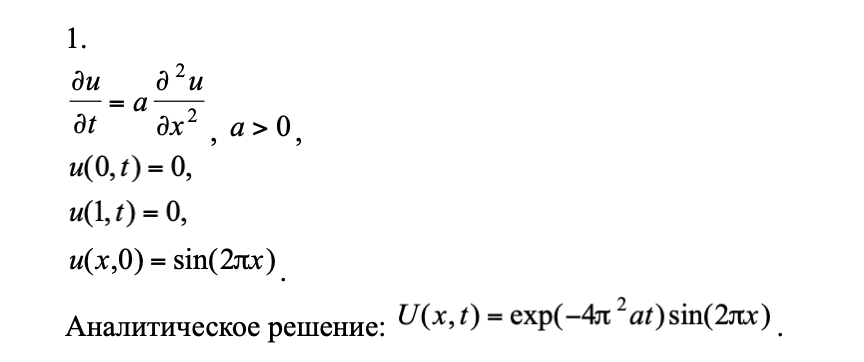

In [36]:
a, b, c = 1.0, 0.0, 0.0  # Только диффузия

x_l, x_r = 0.0, 1.0

# Граничные условия типа Дирихле
boundary_funcs = {
    "x_l": {
        "type": "dirichlet",
        "value": lambda t: torch.zeros_like(t)
    },
    "x_r": {
        "type": "dirichlet",
        "value": lambda t: torch.zeros_like(t)
    }
}

# Начальное условие
initial_func = lambda x: torch.sin(2 * np.pi * x)

# Аналитическое решение
def exact_solution(x, t, a, b, c):
    return torch.exp(-4 * np.pi**2 * a * t) * torch.sin(2 * np.pi * x)

x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.252278
Epoch 300, Loss: -0.777651
Epoch 600, Loss: -1.805954
Epoch 900, Loss: -2.789264
Epoch 1200, Loss: -3.576566
Epoch 1500, Loss: -4.568092
Epoch 1800, Loss: -5.439886
Epoch 2100, Loss: -6.357911
Epoch 2400, Loss: -7.177392
Epoch 2700, Loss: -7.687856
Epoch 3000, Loss: -8.797648
Epoch 3300, Loss: -9.213995
Epoch 3600, Loss: -9.553387
Epoch 3900, Loss: -10.302174
Epoch 4200, Loss: -11.100217
Epoch 4500, Loss: -11.422440
Epoch 4800, Loss: -10.276028
Epoch 5100, Loss: -10.674156
Epoch 5400, Loss: -9.057319
Epoch 5700, Loss: -12.171579
Epoch 6000, Loss: -12.230077
Epoch 6300, Loss: -12.289358
Epoch 6600, Loss: -12.334873
Epoch 6900, Loss: -12.414436
Epoch 7200, Loss: -12.491308
Epoch 7500, Loss: -12.575956
Epoch 7800, Loss: -12.515669
Epoch 8100, Loss: -12.553032
Epoch 8400, Loss: -8.291675
Epoch 8700, Loss: -12.935928
Epoch 9000, Loss: -11.405487
Epoch 9300, Loss: -12.539475
Epoch 9600, Loss: -13.009204
Epoch 9900, Loss: -13.270462


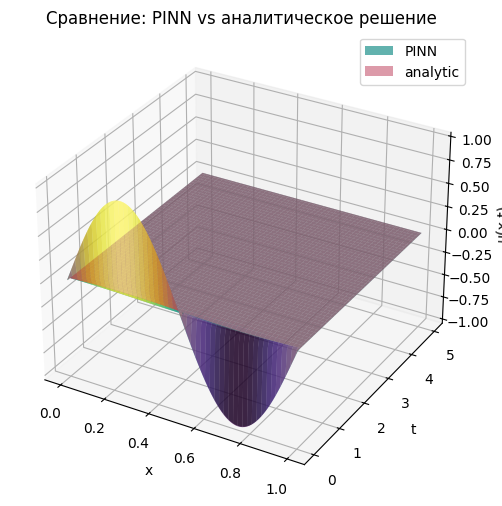

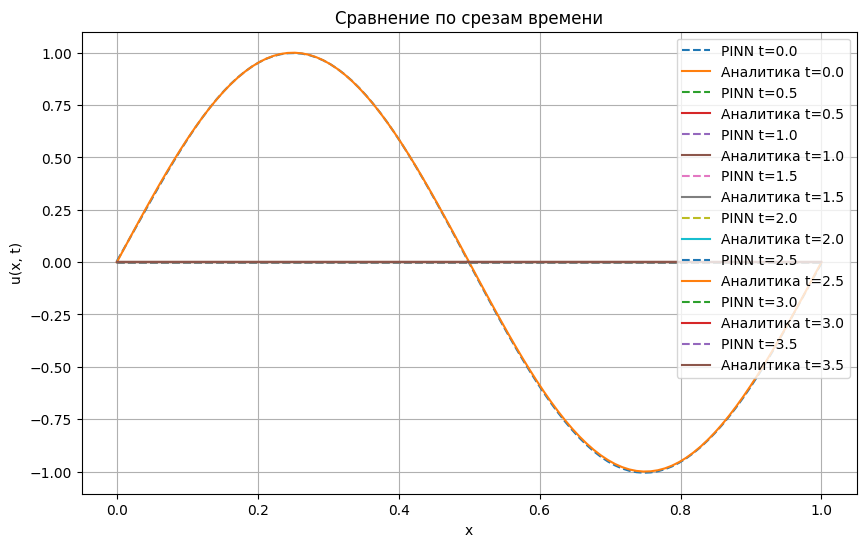

In [37]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

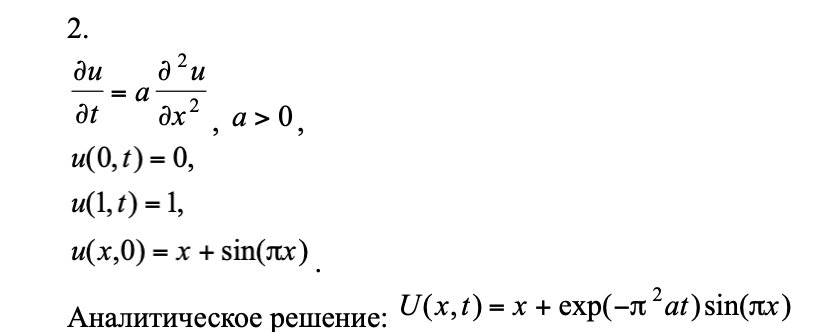

In [38]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, 1.0

boundary_funcs = {
    "x_l": {
        "type": "dirichlet",
        "value": lambda t: torch.zeros_like(t)
    },
    "x_r": {
        "type": "dirichlet",
        "value": lambda t: torch.ones_like(t)
    }
}

initial_func = lambda x: x + torch.sin(np.pi * x)

def exact_solution(x, t, a, b, c):
    return x + torch.exp(-np.pi**2 * a * t) * torch.sin(np.pi * x)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 1.261822
Epoch 300, Loss: -0.878401
Epoch 600, Loss: -1.813441
Epoch 900, Loss: -2.734074
Epoch 1200, Loss: -3.652422
Epoch 1500, Loss: -4.537162
Epoch 1800, Loss: -5.409781
Epoch 2100, Loss: -6.328444
Epoch 2400, Loss: -7.150406
Epoch 2700, Loss: -7.873456
Epoch 3000, Loss: -8.714029
Epoch 3300, Loss: -9.067945
Epoch 3600, Loss: -9.533492
Epoch 3900, Loss: -8.724032
Epoch 4200, Loss: -11.059593
Epoch 4500, Loss: -11.590585
Epoch 4800, Loss: -11.963976
Epoch 5100, Loss: -12.089405
Epoch 5400, Loss: -12.343933
Epoch 5700, Loss: -12.615175
Epoch 6000, Loss: -1.886003
Epoch 6300, Loss: -12.722214
Epoch 6600, Loss: -12.779685
Epoch 6900, Loss: -12.827234
Epoch 7200, Loss: -2.986624
Epoch 7500, Loss: -11.812194
Epoch 7800, Loss: -13.042766
Epoch 8100, Loss: -13.039124
Epoch 8400, Loss: -13.134693
Epoch 8700, Loss: -13.208458
Epoch 9000, Loss: -13.286015
Epoch 9300, Loss: -13.395557
Epoch 9600, Loss: -10.988771
Epoch 9900, Loss: -12.375032


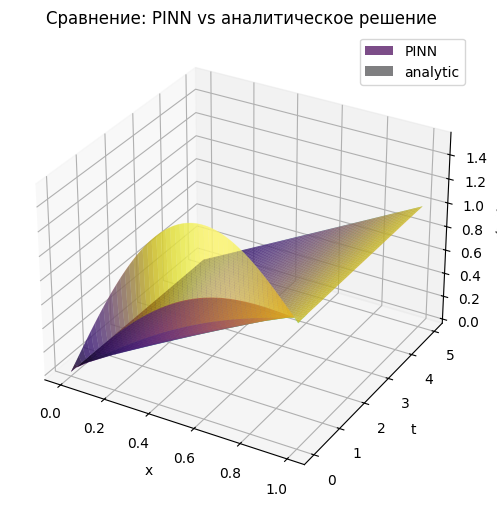

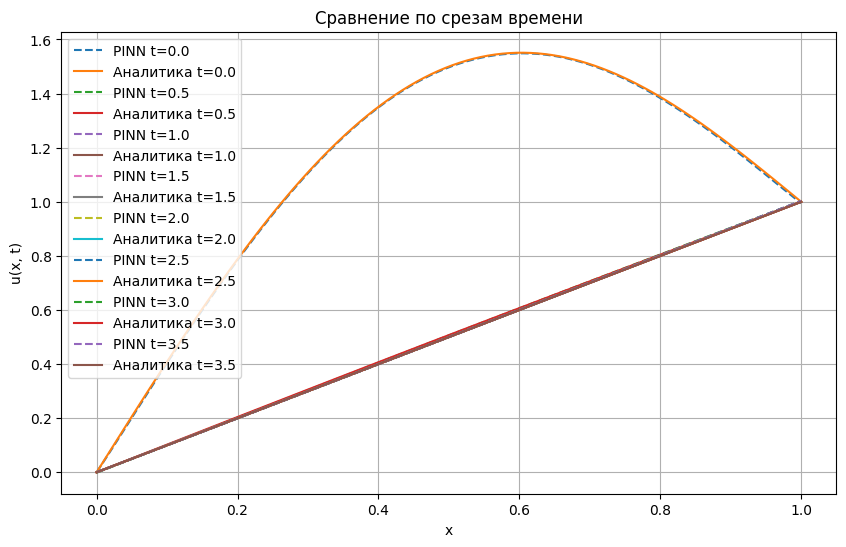

In [39]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

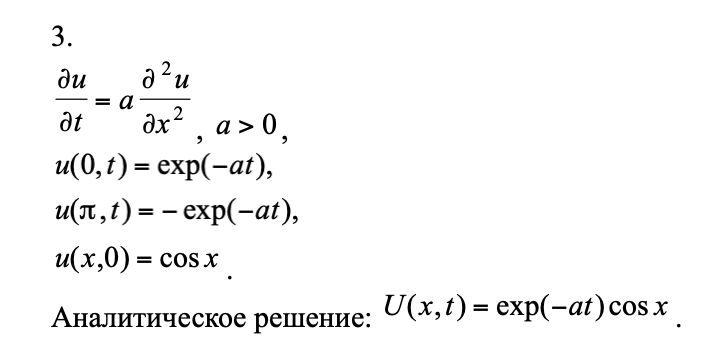

In [40]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, np.pi

boundary_funcs = {
    "x_l": {
        "type": "dirichlet",
        "value": lambda t: torch.exp(-a * t)
    },
    "x_r": {
        "type": "dirichlet",
        "value": lambda t: -torch.exp(-a * t)
    }
}

initial_func = lambda x: torch.cos(x)

def exact_solution(x, t, a, b, c):
    return torch.exp(-a * t) * torch.cos(x)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.313295
Epoch 300, Loss: -0.908506
Epoch 600, Loss: -1.811560
Epoch 900, Loss: -2.711458
Epoch 1200, Loss: -3.615145
Epoch 1500, Loss: -4.514729
Epoch 1800, Loss: -5.405789
Epoch 2100, Loss: -6.307995
Epoch 2400, Loss: -7.191356
Epoch 2700, Loss: -8.014562
Epoch 3000, Loss: 8.687607
Epoch 3300, Loss: -9.271065
Epoch 3600, Loss: -9.853510
Epoch 3900, Loss: -10.463033
Epoch 4200, Loss: -11.057874
Epoch 4500, Loss: -11.256294
Epoch 4800, Loss: -11.807825
Epoch 5100, Loss: -12.547243
Epoch 5400, Loss: -13.133638
Epoch 5700, Loss: -13.535260
Epoch 6000, Loss: -13.794177
Epoch 6300, Loss: -13.861451
Epoch 6600, Loss: -13.914386
Epoch 6900, Loss: -13.957835
Epoch 7200, Loss: -14.028647
Epoch 7500, Loss: -14.066755
Epoch 7800, Loss: -12.688391
Epoch 8100, Loss: -14.252184
Epoch 8400, Loss: -14.339058
Epoch 8700, Loss: -14.442642
Epoch 9000, Loss: -14.558854
Epoch 9300, Loss: -14.593348
Epoch 9600, Loss: -14.805757
Epoch 9900, Loss: -14.915594


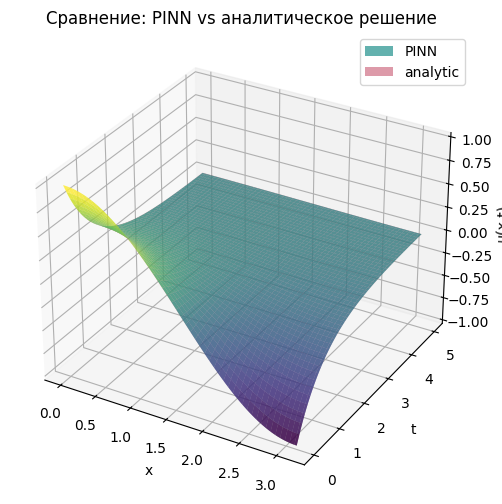

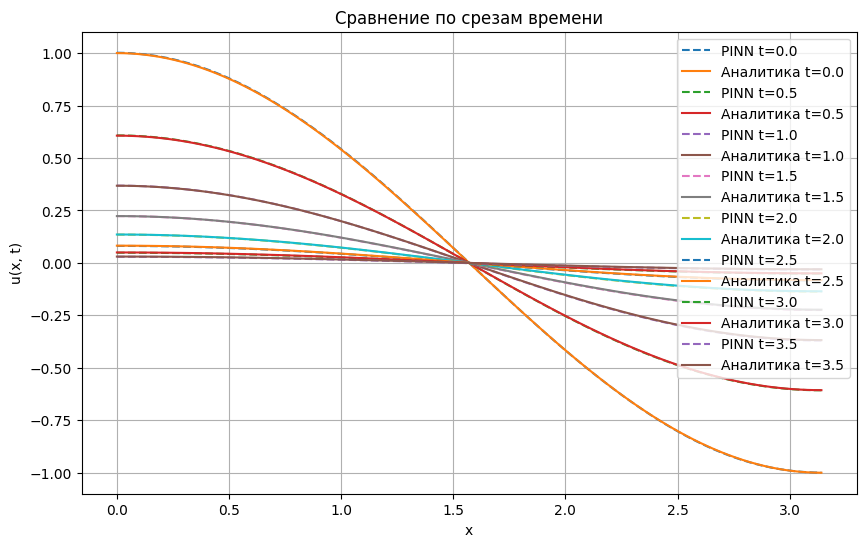

In [41]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

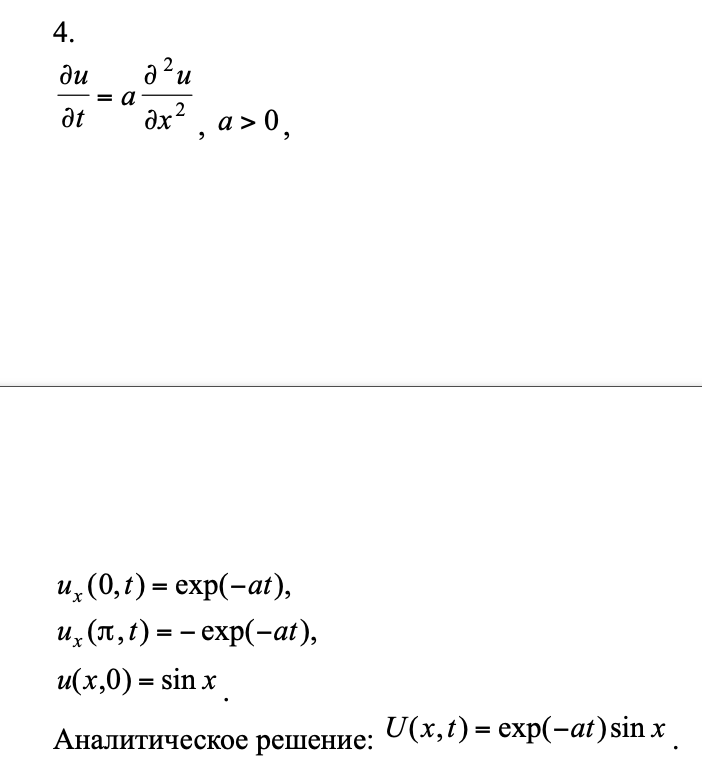

In [42]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, np.pi

boundary_funcs = {
    "x_l": {
        "type": "neumann",
        "value": lambda t: torch.exp(-a * t)
    },
    "x_r": {
        "type": "neumann",
        "value": lambda t: -torch.exp(-a * t)
    }
}

initial_func = lambda x: torch.sin(x)

def exact_solution(x, t, a, b, c):
    return torch.exp(-a * t) * torch.sin(x)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.433275
Epoch 300, Loss: -0.912670
Epoch 600, Loss: -1.812974
Epoch 900, Loss: -2.697414
Epoch 1200, Loss: -3.608664
Epoch 1500, Loss: -4.518250
Epoch 1800, Loss: -5.414963
Epoch 2100, Loss: -6.241458
Epoch 2400, Loss: -7.050571
Epoch 2700, Loss: -8.031448
Epoch 3000, Loss: -8.866529
Epoch 3300, Loss: -9.782441
Epoch 3600, Loss: -10.643491
Epoch 3900, Loss: -11.481231
Epoch 4200, Loss: -12.301562
Epoch 4500, Loss: -12.322052
Epoch 4800, Loss: -12.657718
Epoch 5100, Loss: -13.009285
Epoch 5400, Loss: -13.373856
Epoch 5700, Loss: -13.710546
Epoch 6000, Loss: -14.111574
Epoch 6300, Loss: -14.423423
Epoch 6600, Loss: -14.700911
Epoch 6900, Loss: -15.241122
Epoch 7200, Loss: -15.297623
Epoch 7500, Loss: -15.786680
Epoch 7800, Loss: -15.432927
Epoch 8100, Loss: -15.602787
Epoch 8400, Loss: -15.646358
Epoch 8700, Loss: -15.690462
Epoch 9000, Loss: -15.153751
Epoch 9300, Loss: -15.781872
Epoch 9600, Loss: -13.471020
Epoch 9900, Loss: -15.901690


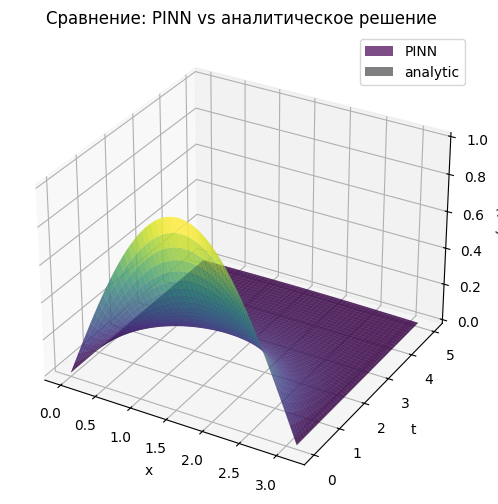

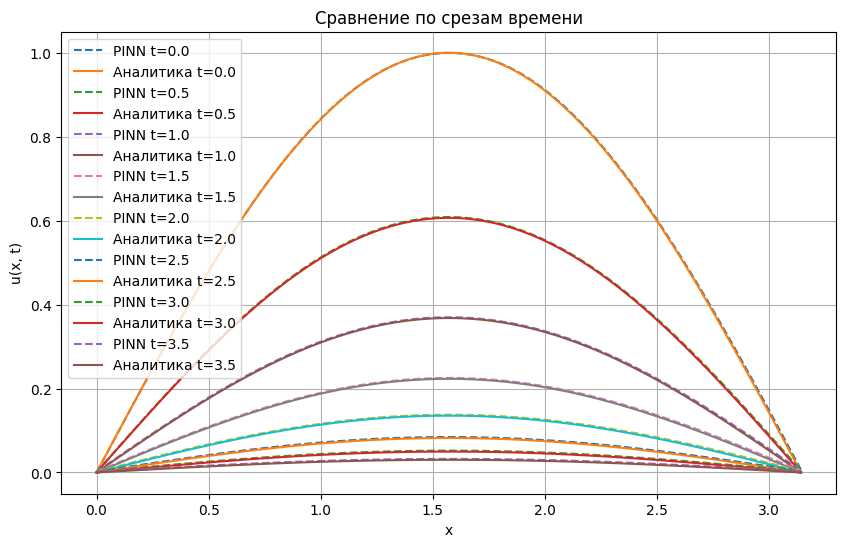

In [43]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

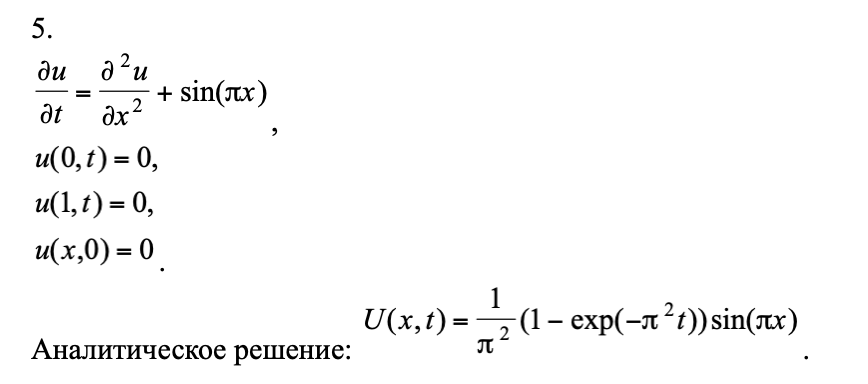

In [44]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, 1.0

boundary_funcs = {
    "x_l": {
        "type": "dirichlet",
        "value": lambda t: torch.zeros_like(t)
    },
    "x_r": {
        "type": "dirichlet",
        "value": lambda t: torch.zeros_like(t)
    }
}

initial_func = lambda x: torch.zeros_like(x)

def forcing_fn(x, t):
    return torch.sin(np.pi * x)

def exact_solution(x, t, a, b, c):
    return (1 / np.pi**2) * (1 - torch.exp(-np.pi**2 * t)) * torch.sin(np.pi * x)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.260911
Epoch 300, Loss: -0.911653
Epoch 600, Loss: -1.811828
Epoch 900, Loss: -2.715142
Epoch 1200, Loss: -3.615165
Epoch 1500, Loss: -4.514757
Epoch 1800, Loss: -5.318388
Epoch 2100, Loss: -6.217245
Epoch 2400, Loss: -7.090500
Epoch 2700, Loss: -7.964824
Epoch 3000, Loss: -8.834448
Epoch 3300, Loss: -9.592983
Epoch 3600, Loss: -10.070055
Epoch 3900, Loss: -10.476921
Epoch 4200, Loss: -10.895342
Epoch 4500, Loss: -10.630544
Epoch 4800, Loss: -11.777383
Epoch 5100, Loss: -12.303432
Epoch 5400, Loss: -12.757364
Epoch 5700, Loss: -12.766562
Epoch 6000, Loss: -13.592679
Epoch 6300, Loss: -13.425400
Epoch 6600, Loss: -13.512291
Epoch 6900, Loss: -13.571808
Epoch 7200, Loss: -13.627869
Epoch 7500, Loss: -13.687439
Epoch 7800, Loss: -13.753819
Epoch 8100, Loss: -13.829082
Epoch 8400, Loss: -13.910204
Epoch 8700, Loss: -13.997969
Epoch 9000, Loss: -14.074095
Epoch 9300, Loss: -14.159874
Epoch 9600, Loss: -13.965794
Epoch 9900, Loss: -14.389244


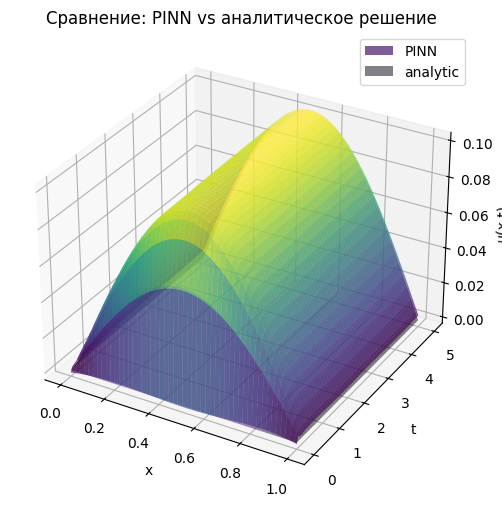

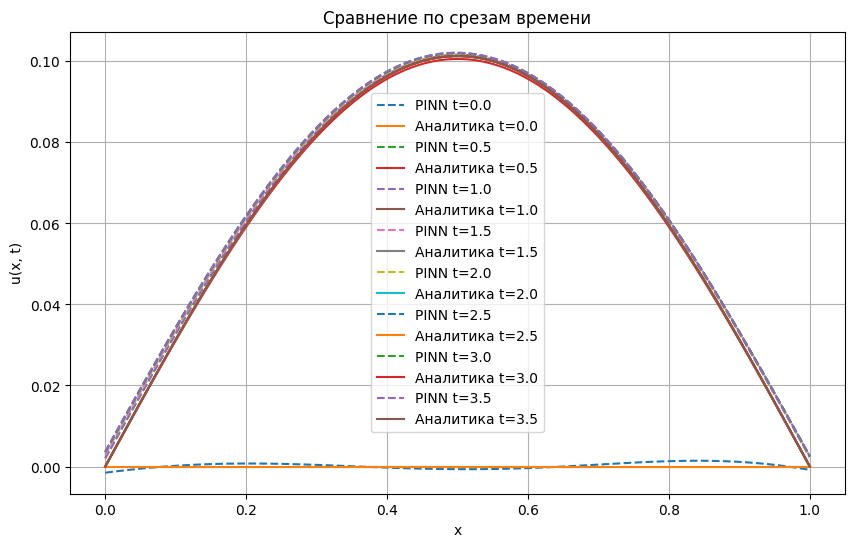

In [45]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r, forcing_fn=forcing_fn)

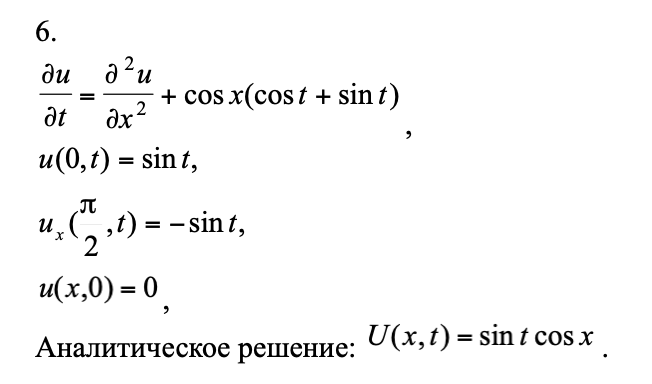

In [46]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, np.pi / 2

boundary_funcs = {
    "x_l": {
        "type": "dirichlet",
        "value": lambda t: torch.sin(t)
    },
    "x_r": {
        "type": "neumann",
        "value": lambda t: -torch.sin(t)
    }
}

initial_func = lambda x: torch.zeros_like(x)

def forcing_fn(x, t):
    return torch.cos(x) * (torch.cos(t) + torch.sin(t))

def exact_solution(x, t, a, b, c):
    return torch.sin(t) * torch.cos(x)

x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.817667
Epoch 300, Loss: -0.916891
Epoch 600, Loss: -1.832573
Epoch 900, Loss: -2.740646
Epoch 1200, Loss: -3.643355
Epoch 1500, Loss: -4.545411
Epoch 1800, Loss: -5.436401
Epoch 2100, Loss: -6.315022
Epoch 2400, Loss: -7.192287
Epoch 2700, Loss: -8.087790
Epoch 3000, Loss: -8.942194
Epoch 3300, Loss: -9.685585
Epoch 3600, Loss: -9.823030
Epoch 3900, Loss: -10.184243
Epoch 4200, Loss: -10.184965
Epoch 4500, Loss: -10.889091
Epoch 4800, Loss: -11.305172
Epoch 5100, Loss: -11.195848
Epoch 5400, Loss: -12.051920
Epoch 5700, Loss: -12.398682
Epoch 6000, Loss: -12.779772
Epoch 6300, Loss: -12.596297
Epoch 6600, Loss: -12.941651
Epoch 6900, Loss: -13.825171
Epoch 7200, Loss: -13.784462
Epoch 7500, Loss: -14.345052
Epoch 7800, Loss: -13.192125
Epoch 8100, Loss: -13.568289
Epoch 8400, Loss: -13.862617
Epoch 8700, Loss: -13.933052
Epoch 9000, Loss: -14.005068
Epoch 9300, Loss: -14.085955
Epoch 9600, Loss: -14.142992
Epoch 9900, Loss: -14.218239


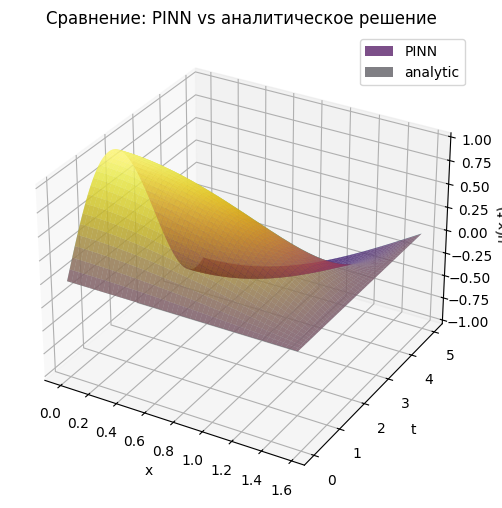

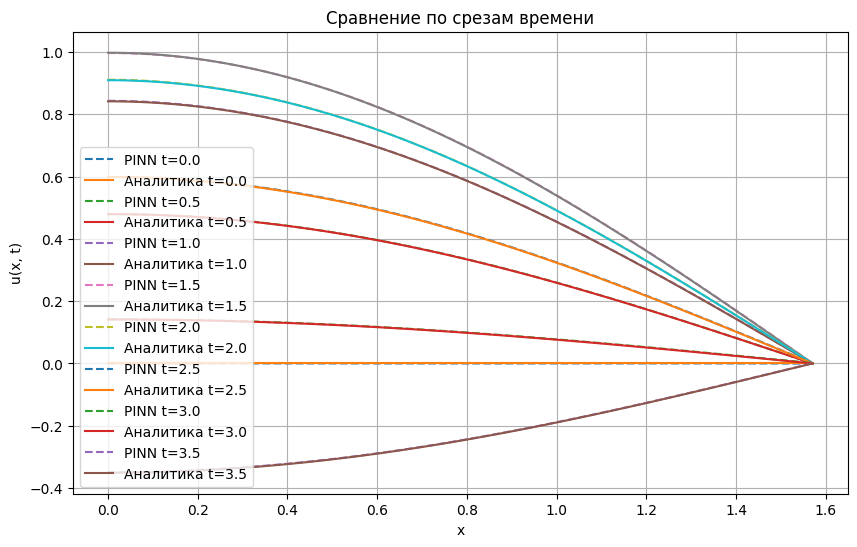

In [47]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r, forcing_fn=forcing_fn)

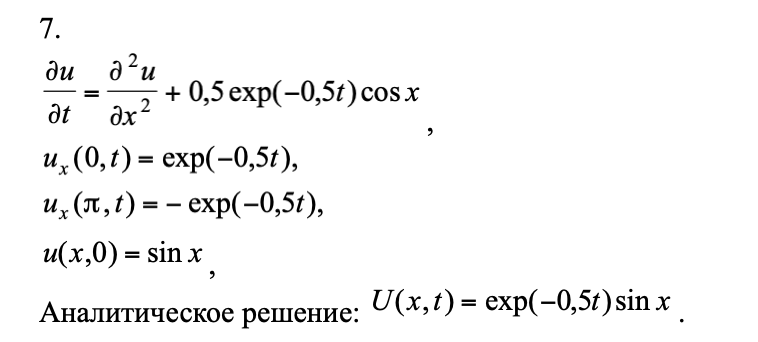

In [59]:
a, b, c = 1.0, 0.0, 0.0
x_l, x_r = 0.0, np.pi

boundary_funcs = {
    "x_l": {
        "type": "neumann",
        "value": lambda t: torch.exp(-0.5 * t)
    },
    "x_r": {
        "type": "neumann",
        "value": lambda t: -torch.exp(-0.5 * t)
    }
}

initial_func = lambda x: torch.sin(x)

def forcing_fn(x, t):
    return 0.5 * torch.exp(-0.5 * t) * torch.cos(x)

def exact_solution(x, t, a, b, c):
    return torch.exp(-0.5 * t) * torch.sin(x)

x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.557766
Epoch 300, Loss: -0.916349
Epoch 600, Loss: -1.819216
Epoch 900, Loss: -2.720727
Epoch 1200, Loss: -3.622741
Epoch 1500, Loss: -4.521772
Epoch 1800, Loss: -5.421423
Epoch 2100, Loss: -6.309259
Epoch 2400, Loss: -7.152102
Epoch 2700, Loss: -8.067529
Epoch 3000, Loss: -8.924902
Epoch 3300, Loss: -9.625604
Epoch 3600, Loss: -10.401678
Epoch 3900, Loss: -11.201539
Epoch 4200, Loss: -11.427864
Epoch 4500, Loss: -11.669342
Epoch 4800, Loss: -13.279430
Epoch 5100, Loss: -13.299044
Epoch 5400, Loss: -13.354924
Epoch 5700, Loss: -13.399067
Epoch 6000, Loss: -13.446985
Epoch 6300, Loss: -13.498871
Epoch 6600, Loss: -13.555669
Epoch 6900, Loss: -13.615261
Epoch 7200, Loss: -13.699364
Epoch 7500, Loss: -13.778252
Epoch 7800, Loss: -13.835081
Epoch 8100, Loss: -13.964912
Epoch 8400, Loss: -14.055199
Epoch 8700, Loss: -14.182701
Epoch 9000, Loss: -13.909771
Epoch 9300, Loss: -14.290554
Epoch 9600, Loss: -14.288399
Epoch 9900, Loss: -14.346003


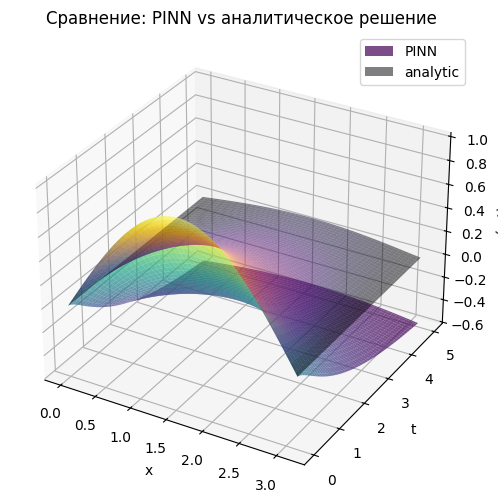

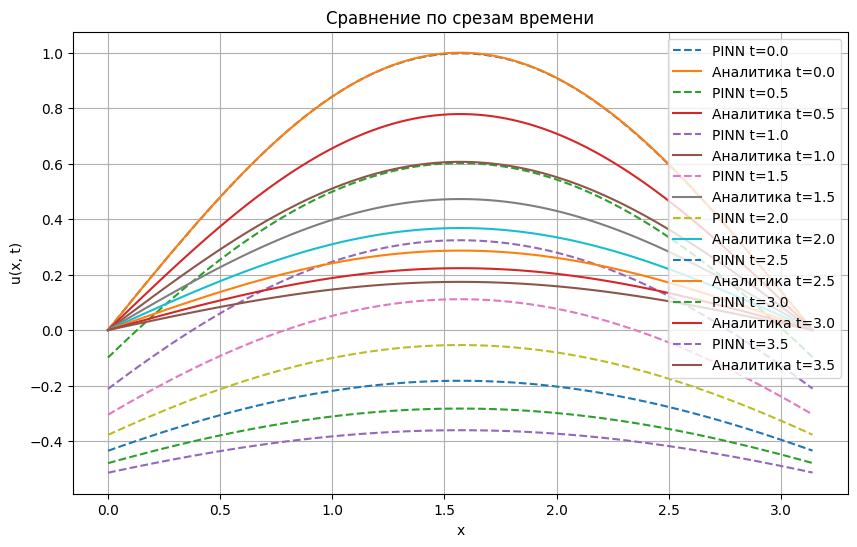

In [60]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="heat", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

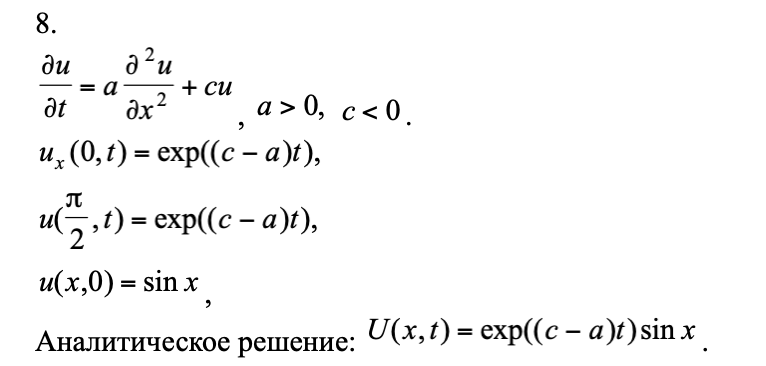

In [50]:
a, b, c = 1.0, 0.0, -0.5  # Пример значений: a > 0, c < 0
x_l, x_r = 0.0, np.pi / 2

boundary_funcs = {
    "x_l": {
        "type": "neumann",
        "value": lambda t: torch.exp((c - a) * t)
    },
    "x_r": {
        "type": "dirichlet",  # Значение u
        "value": lambda t: torch.exp((c - a) * t)
    }
}

initial_func = lambda x: torch.sin(x)

def exact_solution(x, t, a, b, c):
    return torch.exp((c - a) * t) * torch.sin(x)

x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.352650
Epoch 300, Loss: -0.906672
Epoch 600, Loss: -1.809279
Epoch 900, Loss: -2.710149
Epoch 1200, Loss: -3.610503
Epoch 1500, Loss: -4.510051
Epoch 1800, Loss: -5.409774
Epoch 2100, Loss: -6.203748
Epoch 2400, Loss: -6.979746
Epoch 2700, Loss: -7.933707
Epoch 3000, Loss: -8.808853
Epoch 3300, Loss: -9.665829
Epoch 3600, Loss: -10.536662
Epoch 3900, Loss: -11.344971
Epoch 4200, Loss: -11.653888
Epoch 4500, Loss: -11.782616
Epoch 4800, Loss: -11.872229
Epoch 5100, Loss: -11.963771
Epoch 5400, Loss: -10.437593
Epoch 5700, Loss: -12.211554
Epoch 6000, Loss: -12.335632
Epoch 6300, Loss: -12.468252
Epoch 6600, Loss: -12.614138
Epoch 6900, Loss: -4.745357
Epoch 7200, Loss: -12.897356
Epoch 7500, Loss: -13.157364
Epoch 7800, Loss: -9.559418
Epoch 8100, Loss: -13.399766
Epoch 8400, Loss: -13.777015
Epoch 8700, Loss: -13.935055
Epoch 9000, Loss: -14.268671
Epoch 9300, Loss: -13.032310
Epoch 9600, Loss: -14.593803
Epoch 9900, Loss: -14.332569


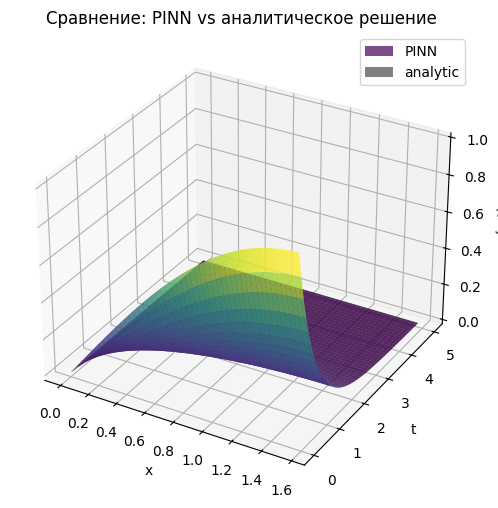

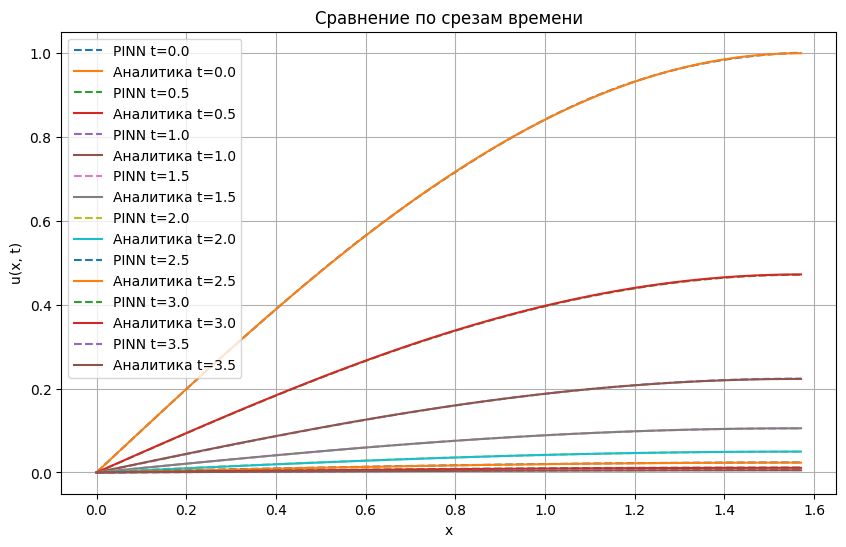

In [51]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="adv_diff_react", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

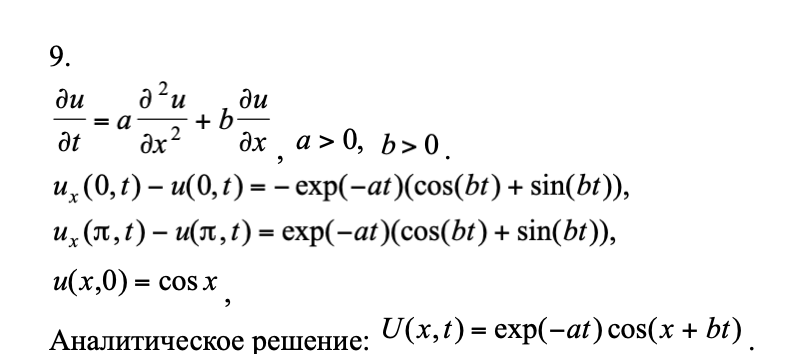

In [55]:
a, b, c = 1.0, 1.0, 0.0
x_l, x_r = 0.0, np.pi

boundary_funcs = {
    "x_l": {
        "type": "robin",  # u_x - u = ...
        "value": lambda t: -torch.exp(-a * t) * (torch.cos(b * t) + torch.sin(b * t))
    },
    "x_r": {
        "type": "robin",
        "value": lambda t: torch.exp(-a * t) * (torch.cos(b * t) + torch.sin(b * t))
    }
}

initial_func = lambda x: torch.cos(x)

def exact_solution(x, t, a, b, c):
    return torch.exp(-a * t) * torch.cos(x + b * t)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.382130
Epoch 300, Loss: -0.847225
Epoch 600, Loss: -1.680964
Epoch 900, Loss: -2.494827
Epoch 1200, Loss: -3.318674
Epoch 1500, Loss: -4.321575
Epoch 1800, Loss: -5.192734
Epoch 2100, Loss: -6.111397
Epoch 2400, Loss: -6.231414
Epoch 2700, Loss: -7.102229
Epoch 3000, Loss: -7.865062
Epoch 3300, Loss: -8.601667
Epoch 3600, Loss: -9.139809
Epoch 3900, Loss: -9.912663
Epoch 4200, Loss: -10.242944
Epoch 4500, Loss: -11.486345
Epoch 4800, Loss: -12.060978
Epoch 5100, Loss: -12.058117
Epoch 5400, Loss: -12.515724
Epoch 5700, Loss: -12.875240
Epoch 6000, Loss: -12.369633
Epoch 6300, Loss: -13.444399
Epoch 6600, Loss: -13.522709
Epoch 6900, Loss: -12.126255
Epoch 7200, Loss: -13.275393
Epoch 7500, Loss: -13.532299
Epoch 7800, Loss: -13.695494
Epoch 8100, Loss: -13.696984
Epoch 8400, Loss: -13.853893
Epoch 8700, Loss: -12.626671
Epoch 9000, Loss: -12.263230
Epoch 9300, Loss: -14.034240
Epoch 9600, Loss: -13.620640
Epoch 9900, Loss: -14.254442


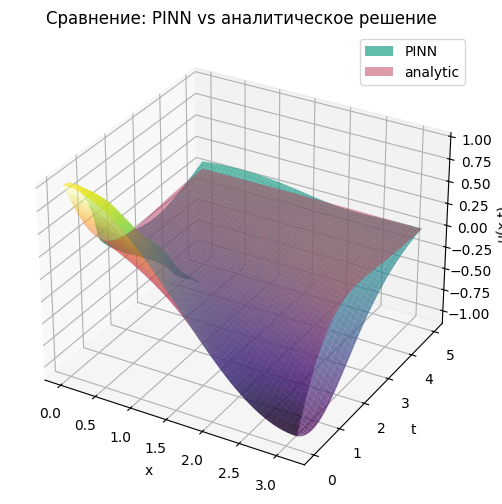

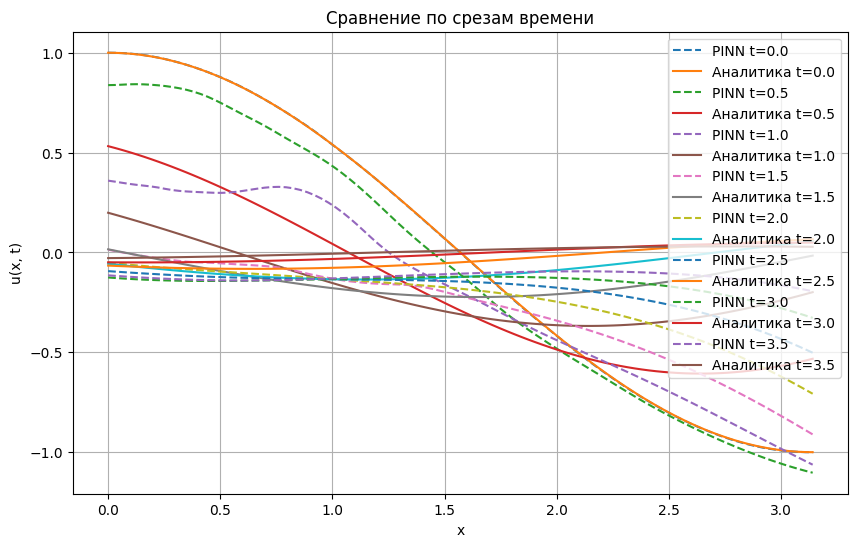

In [56]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="wave", a=a, b=b, c=c, x_l=x_l, x_r=x_r)

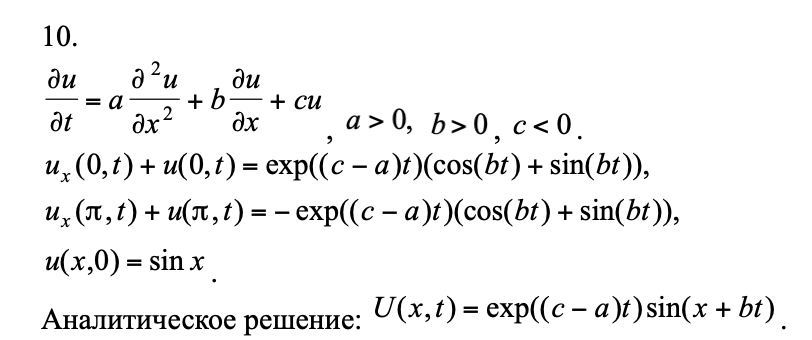

In [57]:
a, b, c = 1.0, 1.0, -1.0
x_l, x_r = 0.0, np.pi

boundary_funcs = {
    "x_l": {
        "type": "robin",  # u_x + u = ...
        "value": lambda t: torch.exp((c - a) * t) * (torch.cos(b * t) + torch.sin(b * t))
    },
    "x_r": {
        "type": "robin",
        "value": lambda t: -torch.exp((c - a) * t) * (torch.cos(b * t) + torch.sin(b * t))
    }
}

initial_func = lambda x: torch.sin(x)

def exact_solution(x, t, a, b, c):
    return torch.exp((c - a) * t) * torch.sin(x + b * t)
x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial = generator(800,800, x_l, x_r)

Epoch 0, Loss: 0.299943
Epoch 300, Loss: -0.902249
Epoch 600, Loss: -1.774172
Epoch 900, Loss: -2.685948
Epoch 1200, Loss: -3.558383
Epoch 1500, Loss: -4.391734
Epoch 1800, Loss: -5.162397
Epoch 2100, Loss: -5.929922
Epoch 2400, Loss: -6.742168
Epoch 2700, Loss: -7.868256
Epoch 3000, Loss: -8.832878
Epoch 3300, Loss: -7.919042
Epoch 3600, Loss: -9.681212
Epoch 3900, Loss: -10.526544
Epoch 4200, Loss: -10.562974
Epoch 4500, Loss: -10.937468
Epoch 4800, Loss: -11.343134
Epoch 5100, Loss: -11.751638
Epoch 5400, Loss: -11.601470
Epoch 5700, Loss: -11.918398
Epoch 6000, Loss: -12.402653
Epoch 6300, Loss: -11.230171
Epoch 6600, Loss: -13.204794
Epoch 6900, Loss: -13.249443
Epoch 7200, Loss: 168.934021
Epoch 7500, Loss: -13.787279
Epoch 7800, Loss: -13.965553
Epoch 8100, Loss: -14.094398
Epoch 8400, Loss: -13.544928
Epoch 8700, Loss: -14.223934
Epoch 9000, Loss: -14.559847
Epoch 9300, Loss: -14.664560
Epoch 9600, Loss: -14.522191
Epoch 9900, Loss: -9.839901


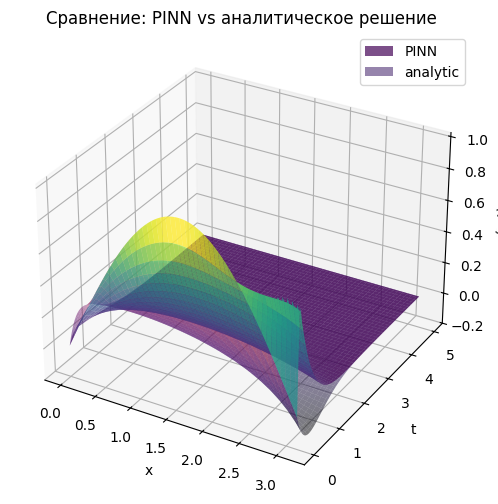

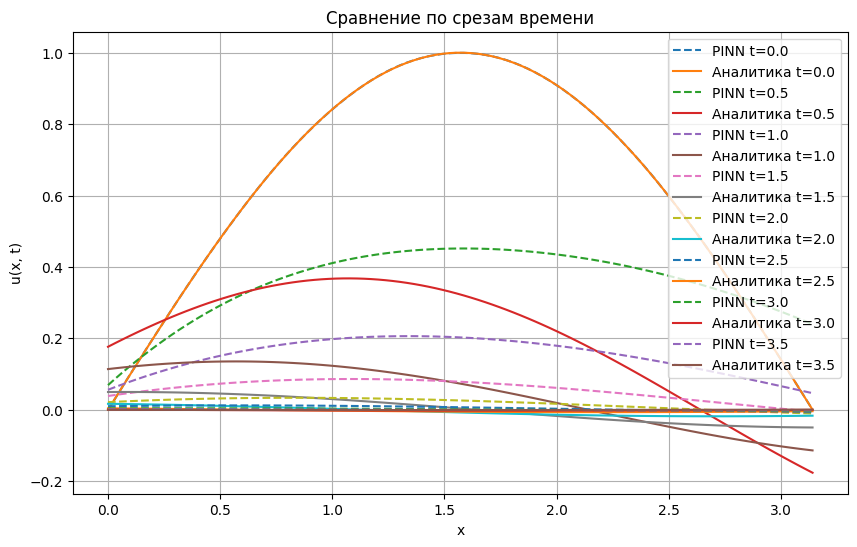

In [58]:
model = PINN().to(device)
train(model, x_interior, t_interior, x_boundary_0, t_boundary, x_boundary_pi, t_boundary_pi, x_initial, t_initial, boundary_funcs, initial_func, exact_solution, equation="adv_diff_react", a=a, b=b, c=c, x_l=x_l, x_r=x_r)